### Code to plot a telemetry profile (Beta!)
#### 2021 01 20 CJH

In [110]:
from networktables import NetworkTables
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

#### choose the address of the network tables server

In [416]:
odometry_list = None  # initialize this for later
# ip = '172.22.11.2' # robot
# ip = 'roboRIO-2429-FRC.local'
ip = 'localhost'  # simulation
NetworkTables.initialize(server=ip)

False

In [379]:
NetworkTables.addConnectionListener(connectionListener, immediateNotify=True)

ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=430556.859, protocol_version=768) ; Connected=True


#### get the SmartDashboard table from the network tables server so we can query it

In [380]:
sd = NetworkTables.getTable("SmartDashboard")

#### get the odometry entries - currently set up as a list of 256 strings due to the limitations of what you can store in network tables 

In [426]:
# all on one
def get_data():
    # this was a lot simpler but stupid network tables can only take 256 values per array
    odometry_list = sd.getStringArray('Odometry_List',0)
    all_floats = [ [float(s[i*10:(i+1)*10]) for i in range(6)] for s in odometry_list] # i made all columns 10 characters wide
    df = pd.DataFrame(all_floats, columns=['POSE_X', 'POSE_Y', 'POSE_ROT', 'LEFT_ENCODER', 'RIGHT_ENCODER', 'NAVX_YAW'])
    scale = 10 # doesn't do anything yet - quiver keeps autoscaling
    df['DELTA'] = np.sqrt(np.asarray(df.diff()['POSE_X']**2) + np.asarray(df.diff()['POSE_Y']**2))
    df['RADIANS'] = df['POSE_ROT'] * np.pi/180
    df['VEC_X'] = df['DELTA']* np.cos(df['RADIANS'])*scale
    df['VEC_Y'] = df['DELTA']* np.sin(df['RADIANS'])*scale
    df.at[0, 'VEC_X'] = df.at[1, 'VEC_X'] 
    df.at[0, 'VEC_Y'] = df.at[1, 'VEC_Y']
    df.at[0, 'DELTA'] = df.at[1, 'DELTA'] 
    df[(df.index) % 20 == 0]
    return df, odometry_list

#### step by step - getting data, parsing data, extra calculations

In [381]:
odometry_list = sd.getStringArray('Odometry_List',0) # grab live from the simulation

In [427]:
example = odometry_list[0]
example = example.replace(' ', '#')
print(f'Example: {example}\nx:{example[0:10]} y:{example[10:20]} rot:{example[20:30]} lenc:{example[30:40]} renc:{example[40:50]} yaw:{example[50:60]}')

Example: ####+0.62#####+7.90####+77.92#####+2.98######-3.1####-77.92
x:####+0.62# y:####+7.90# rot:###+77.92# lenc:####+2.98# renc:#####-3.1# yaw:###-77.92


In [452]:
odometry_list[::50]

('    +0.62     +7.90    +77.92     +2.98      -3.1    -77.92',
 '    +2.92     +3.37    +71.80     +7.33      -7.5    -71.80',
 '    +8.64     +5.06    -73.28    +11.90     -11.6    +73.28',
 '   +12.72     +1.28   +121.60    +16.24     -15.6   -121.60',
 '    +6.41     +2.92   +162.06    +21.50     -21.2   -162.06',
 '    +0.76     +4.50   +111.53    +25.04     -24.7   -111.53')

### python is a high level language!
* list comprehension does for loops in one line (nested loops too!)
* pandas makes a great table (called dataframes) from a dictionary (or lists if you provide the column names)

In [458]:
# the regular way - gets a single colimn from the data
x = []  # make an empty list
print(f'x starts with {len(x)} values ...', end=' ')
data_length = len(odometry_list)  # figure our how long our data is
for i in range(data_length):  # start a for loop, remember the : and to indent the next lines
    current_line = odometry_list[i] # get one line from our odometry data
    x_value_string = current_line[0:10]  # get characters 0 through 9 and convert to float
    x_value_float = float(x_value_string)
    x.append(x_value_float)
print(f'and x ends with {len(x)} values')

x starts with 0 values ... and x ends with 255 values


In [459]:
# do it for all the data
x = [float(i[0:10]) for i in odometry_list]  # python list comprehension example
y = [float(i[10:20]) for i in odometry_list]
rot = [float(i[20:30]) for i in odometry_list]
l_dist = [float(i[30:40]) for i in odometry_list]
r_dist = [float(i[40:50]) for i in odometry_list]
yaw = [float(i[50:60]) for i in odometry_list]
# make a pandas dataframe object from our data
df = pd.DataFrame({'POSE_X':x, 'POSE_Y':y, 'POSE_ROT':rot, 'LEFT_ENCODER':l_dist, 'RIGHT_ENCODER':r_dist, 'NAVX_YAW':yaw})

In [447]:
# faster way to get the same thing, but requires more python thinking
all_floats = [ [float(s[i*10:(i+1)*10]) for i in range(6)] for s in odometry_list]
df2 = pd.DataFrame(all_floats, columns=['POSE_X', 'POSE_Y', 'POSE_ROT', 'LEFT_ENCODER', 'RIGHT_ENCODER', 'NAVX_YAW'])
#df2[(df2.index) % 20 == 0]

#### take a quick look at the pandas datatable from the odometry

In [461]:
# want to do typical python slicing but that does not work with pandas so use a little logic to cut down the table for displaying here
df[(df.index) % 25 == 0]

,POSE_X,POSE_Y,POSE_ROT,LEFT_ENCODER,RIGHT_ENCODER,NAVX_YAW
0,0.62,7.90,77.92,2.98,-3.1,-77.92
25,1.67,2.62,-101.84,5.34,-5.2,101.84
50,2.92,3.37,71.80,7.33,-7.5,-71.80
75,4.17,7.11,-65.11,9.66,-9.6,65.11
100,8.64,5.06,-73.28,11.90,-11.6,73.28
125,14.03,4.56,-72.15,13.92,-13.7,72.15
150,12.72,1.28,121.60,16.24,-15.6,-121.60
175,11.72,7.45,-122.77,18.50,-18.4,122.77
200,6.41,2.92,162.06,21.50,-21.2,-162.06
225,2.45,0.43,122.05,23.67,-23.3,-122.05


#### pandas is awesome - think of it as excel/google sheets but really fast
* calculate the distance between points as a new column 'DELTA'
* use the heading to get data for the plotting direction arrows to give ourselves a velocity vector
* fix some blank lines left by the analysis

In [462]:
scale = 10 # doesn't do anything yet - quiver keeps autoscaling
df['DELTA'] = np.sqrt(np.asarray(df.diff()['POSE_X']**2) + np.asarray(df.diff()['POSE_Y']**2))
df['RADIANS'] = df['POSE_ROT'] * np.pi/180
df['VEC_X'] = df['DELTA']* np.cos(df['RADIANS'])*scale
df['VEC_Y'] = df['DELTA']* np.sin(df['RADIANS'])*scale
df.at[0, 'VEC_X'] = df.at[1, 'VEC_X'] 
df.at[0, 'VEC_Y'] = df.at[1, 'VEC_Y']
df.at[0, 'DELTA'] = df.at[1, 'DELTA'] 
df[(df.index) % 25 == 0]

,POSE_X,POSE_Y,POSE_ROT,LEFT_ENCODER,RIGHT_ENCODER,NAVX_YAW,DELTA,RADIANS,VEC_X,VEC_Y
0,0.62,7.90,77.92,2.98,-3.1,-77.92,0.215407,1.359961,1.070515,1.869224
25,1.67,2.62,-101.84,5.34,-5.2,101.84,0.286356,-1.777443,-0.587544,-2.802640
50,2.92,3.37,71.80,7.33,-7.5,-71.80,0.284605,1.253146,0.888921,2.703668
75,4.17,7.11,-65.11,9.66,-9.6,65.11,0.286356,-1.136384,1.205210,-2.597589
100,8.64,5.06,-73.28,11.90,-11.6,73.28,0.470106,-1.278977,1.352472,-4.502313
125,14.03,4.56,-72.15,13.92,-13.7,72.15,0.143178,-1.259255,0.438879,-1.362859
150,12.72,1.28,121.60,16.24,-15.6,-121.60,0.256125,2.122320,-1.342059,2.181485
175,11.72,7.45,-122.77,18.50,-18.4,122.77,0.494065,-2.142741,-2.674215,-4.154344
200,6.41,2.92,162.06,21.50,-21.2,-162.06,0.058310,2.828481,-0.554745,0.179605
225,2.45,0.43,122.05,23.67,-23.3,-122.05,0.250000,2.130174,-1.326648,2.118963


read error: [WinError 10054] An existing connection was forcibly closed by the remote host


ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=453149.859, protocol_version=768) ; Connected=False
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=453149.859, protocol_version=768) ; Connected=False
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=453149.859, protocol_version=768) ; Connected=False
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=453149.859, protocol_version=768) ; Connected=False
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=0, protocol_version=768) ; Connected=True
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=0, protocol_version=768) ; Connected=True
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=0, protocol_version=768) ; Connected=True
ConnectionInfo(remote_id='Robot', remote_ip='localhost', 

read error: [WinError 10054] An existing connection was forcibly closed by the remote host


ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=0, protocol_version=768) ; Connected=False
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=0, protocol_version=768) ; Connected=False
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=0, protocol_version=768) ; Connected=False
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=0, protocol_version=768) ; Connected=False
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=0, protocol_version=768) ; Connected=True
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=0, protocol_version=768) ; Connected=True
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=0, protocol_version=768) ; Connected=True
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=0, pro

read error: [WinError 10054] An existing connection was forcibly closed by the remote host


ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=453454.562, protocol_version=768) ; Connected=False
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=453454.562, protocol_version=768) ; Connected=False
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=453454.562, protocol_version=768) ; Connected=False
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=453454.562, protocol_version=768) ; Connected=False


read error in handshake: [WinError 10054] An existing connection was forcibly closed by the remote host


ConnectionInfo(remote_id=None, remote_ip='localhost', remote_port=1735, last_update=0, protocol_version=768) ; Connected=False
ConnectionInfo(remote_id=None, remote_ip='localhost', remote_port=1735, last_update=0, protocol_version=768) ; Connected=False
ConnectionInfo(remote_id=None, remote_ip='localhost', remote_port=1735, last_update=0, protocol_version=768) ; Connected=False
ConnectionInfo(remote_id=None, remote_ip='localhost', remote_port=1735, last_update=0, protocol_version=768) ; Connected=False
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=0, protocol_version=768) ; Connected=True
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=0, protocol_version=768) ; Connected=True
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=0, protocol_version=768) ; Connected=True
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=0, protocol_versio

read error: [WinError 10054] An existing connection was forcibly closed by the remote host


ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=454044.39, protocol_version=768) ; Connected=False
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=454044.39, protocol_version=768) ; Connected=False
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=454044.39, protocol_version=768) ; Connected=False
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=454044.39, protocol_version=768) ; Connected=False
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=0, protocol_version=768) ; Connected=True
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=0, protocol_version=768) ; Connected=True
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=0, protocol_version=768) ; Connected=True
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remo

read error: [WinError 10054] An existing connection was forcibly closed by the remote host


ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=454122.765, protocol_version=768) ; Connected=False
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=454122.765, protocol_version=768) ; Connected=False
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=454122.765, protocol_version=768) ; Connected=False
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=454122.765, protocol_version=768) ; Connected=False
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=0, protocol_version=768) ; Connected=True
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=0, protocol_version=768) ; Connected=True
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=0, protocol_version=768) ; Connected=True
ConnectionInfo(remote_id='Robot', remote_ip='localhost', 

read error: [WinError 10054] An existing connection was forcibly closed by the remote host


ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=454150.609, protocol_version=768) ; Connected=False
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=454150.609, protocol_version=768) ; Connected=False
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=454150.609, protocol_version=768) ; Connected=False
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=454150.609, protocol_version=768) ; Connected=False
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=0, protocol_version=768) ; Connected=True
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=0, protocol_version=768) ; Connected=True
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=0, protocol_version=768) ; Connected=True
ConnectionInfo(remote_id='Robot', remote_ip='localhost', 

read error: [WinError 10054] An existing connection was forcibly closed by the remote host


ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=0, protocol_version=768) ; Connected=False
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=0, protocol_version=768) ; Connected=False
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=0, protocol_version=768) ; Connected=False
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=0, protocol_version=768) ; Connected=False
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=0, protocol_version=768) ; Connected=True
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=0, protocol_version=768) ; Connected=True
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=0, protocol_version=768) ; Connected=True
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=0, pro

read error: [WinError 10054] An existing connection was forcibly closed by the remote host


ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=455410.687, protocol_version=768) ; Connected=False
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=455410.687, protocol_version=768) ; Connected=False
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=455410.687, protocol_version=768) ; Connected=False
ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=455410.687, protocol_version=768) ; Connected=False


In [400]:
def plot_df(df, arrows=True, save=False, fname='odometry.png'):
    label = "Mapping Odometry from Robot Simulation"
    fig, ax = plt.subplots(figsize=(16,10))
    df.plot.scatter(x='POSE_X', y='POSE_Y',c='POSE_ROT', colormap='viridis', ax=ax, label='sim')
    if arrows:
        ax.quiver(x,y, df['VEC_X'], df['VEC_Y'], df['POSE_ROT'])
    
    plt.text(df.iloc[[0]]['POSE_X'], df.iloc[[0]]['POSE_Y']-.2, 'START', ha='center', size=16)
    plt.text(df.iloc[[-1]]['POSE_X'], df.iloc[[-1]]['POSE_Y']+.2, 'FINISH', ha='center', size=16)
    
    ax.legend(loc='lower right', bbox_to_anchor=(0.1, 0.02), fontsize=14)
    ax.set_title(label, fontsize=16)
    ax.set_ylabel('y position on field', fontsize = 16)
    ax.set_xlabel('x position on field', fontsize = 16)
    plt.tight_layout()
    if save:
        plt.ioff()
        plt.savefig(fname, facecolor='w', bbox_inches='tight', dpi=100)
        plt.close()

    plt.show()


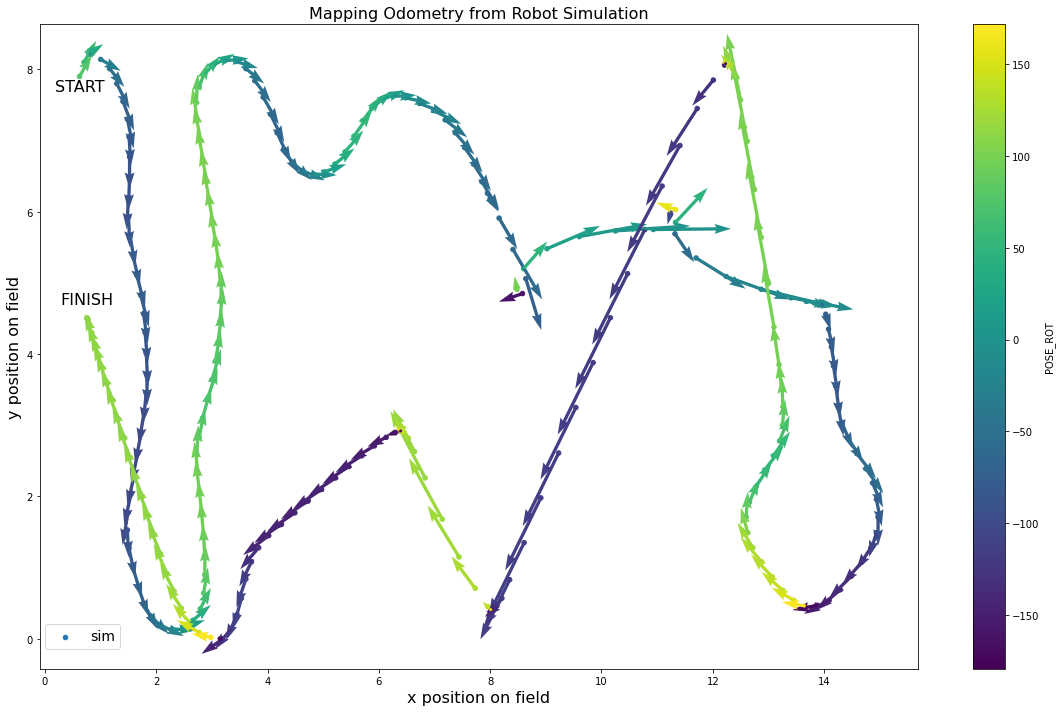

In [415]:
plot_df(df, arrows=True, save=False)

---
#### Pickle the data if desired (pickle writes python data to files for later use)

In [408]:
from datetime import datetime
time_stamp = datetime.now().strftime("%Y%m%d_%H%M%S")
pickle_dir = r'.\pickle'
outfile = pickle_dir + '\\' + time_stamp +'.pkl'
with open(outfile, 'wb') as fp:
    pickle.dump([odometry_list, df], fp)

#### load data from pickle

In [410]:
# get a list of all the files 
import glob
pickle_dir = r'.\pickle'
files = glob.glob(pickle_dir+ '\*')
files

['.\\pickle\\20210121_093111.pkl']

In [424]:
infile = files[-1]
try:
    with open(infile, 'rb') as fp:
        [odometry_list, df] = pickle.load(fp)
except ValueError as e:
    print(f'Missing item  in pickle {infile}, please create it and re-pickle')

In [412]:
df[(df.index) % 50 == 0]

,POSE_X,POSE_Y,POSE_ROT,LEFT_ENCODER,RIGHT_ENCODER,NAVX_YAW,DELTA,RADIANS,VEC_X,VEC_Y
0,0.62,7.90,77.92,2.98,-3.1,-77.92,0.215407,1.359961,1.070515,1.869224
50,2.92,3.37,71.80,7.33,-7.5,-71.80,0.284605,1.253146,0.888921,2.703668
100,8.64,5.06,-73.28,11.90,-11.6,73.28,0.470106,-1.278977,1.352472,-4.502313
150,12.72,1.28,121.60,16.24,-15.6,-121.60,0.256125,2.122320,-1.342059,2.181485
200,6.41,2.92,162.06,21.50,-21.2,-162.06,0.058310,2.828481,-0.554745,0.179605
250,0.76,4.50,111.53,25.04,-24.7,-111.53,0.000000,1.946566,-0.000000,0.000000


In [ ]:
## other stuff to remember in case i need it
def valueChanged(table, key, value, isNew):
    print("valueChanged: key: '%s'; value: %s; isNew: %s" % (key, value, isNew))
def connectionListener(connected, info):
    print(info, "; Connected=%s" % connected)